# Pip and Import

In [1]:
%%capture
# Install Dask or PyArrow for large dataset handling (optional)
%pip install dask pyarrow

# Install TensorFlow and Keras for LSTM
%pip install tensorflow

# Install Hugging Face Transformers for FinBERT
%pip install transformers

# Install Torch for FinBERT model
%pip install torch

# Install NumPy and Pandas for data manipulation
%pip install numpy pandas

# Install Scikit-learn for data preprocessing and evaluation metrics
%pip install scikit-learn

# Install Matplotlib and Seaborn for data visualization
%pip install matplotlib seaborn

# Install Jupyter Notebook extensions (optional, for enhanced notebook features)
%pip install jupyter_contrib_nbextensions

# Install NLTK for text processing
%pip install nltk

# Install yfinance for stock data
%pip install yfinance

# Ensure TensorFlow is installed
%pip install tensorflow

# Install pandas_market_calendars for market calendars
%pip install pandas-market-calendars

# install wordcloud for word cloud visualization
%pip install wordcloud

# install scipy for scientific computing
%pip install scipy==1.10.1

# install gensim for word2vec
%pip install gensim

# install pandas_datareader for stock data
%pip install pandas_datareader

In [2]:
%%capture
# Import necessary libraries for the project
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('all')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_market_calendars as mcal
import gensim
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
IMPORT_FILES = False
TEST = False
YEAR = 2010

# Imports & File Path Definition

In [ ]:
# Define the file path
file_path = "C:/Users/argam/Documents/GitHub/FinTrendLSTM/data/all-the-news-2-1.csv"

# Check if the file exists
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found at {file_path}. Ensure the dataset is downloaded and placed correctly.")

# Load the dataset
news_df = pd.read_csv(file_path,low_memory=False)

# Build the date column by combining year, month, and day
news_df['Date'] = pd.to_datetime(news_df[['year', 'month', 'day']])

# Define the date range
start_date =  "2010-01-01"
end_date = "2020-12-31"

# Filter the dataset for the date range
filtered_news = news_df.loc[(news_df['Date'] >= start_date) & (news_df['Date'] <= end_date)]

def print_head(data):
    data_head = data.head(10).copy()
    # Truncate the strings in 'title' and 'article' columns
    data_head['title'] = data_head['title'].apply(lambda x: x[:15] + '...' if len(x) > 15 else x)
    data_head['article'] = data_head['article'].apply(lambda x: x[:15] + '...' if len(x) > 15 else x)
    print(data_head)
    del data_head

print_head(filtered_news)

#Data Exploration & Visualization


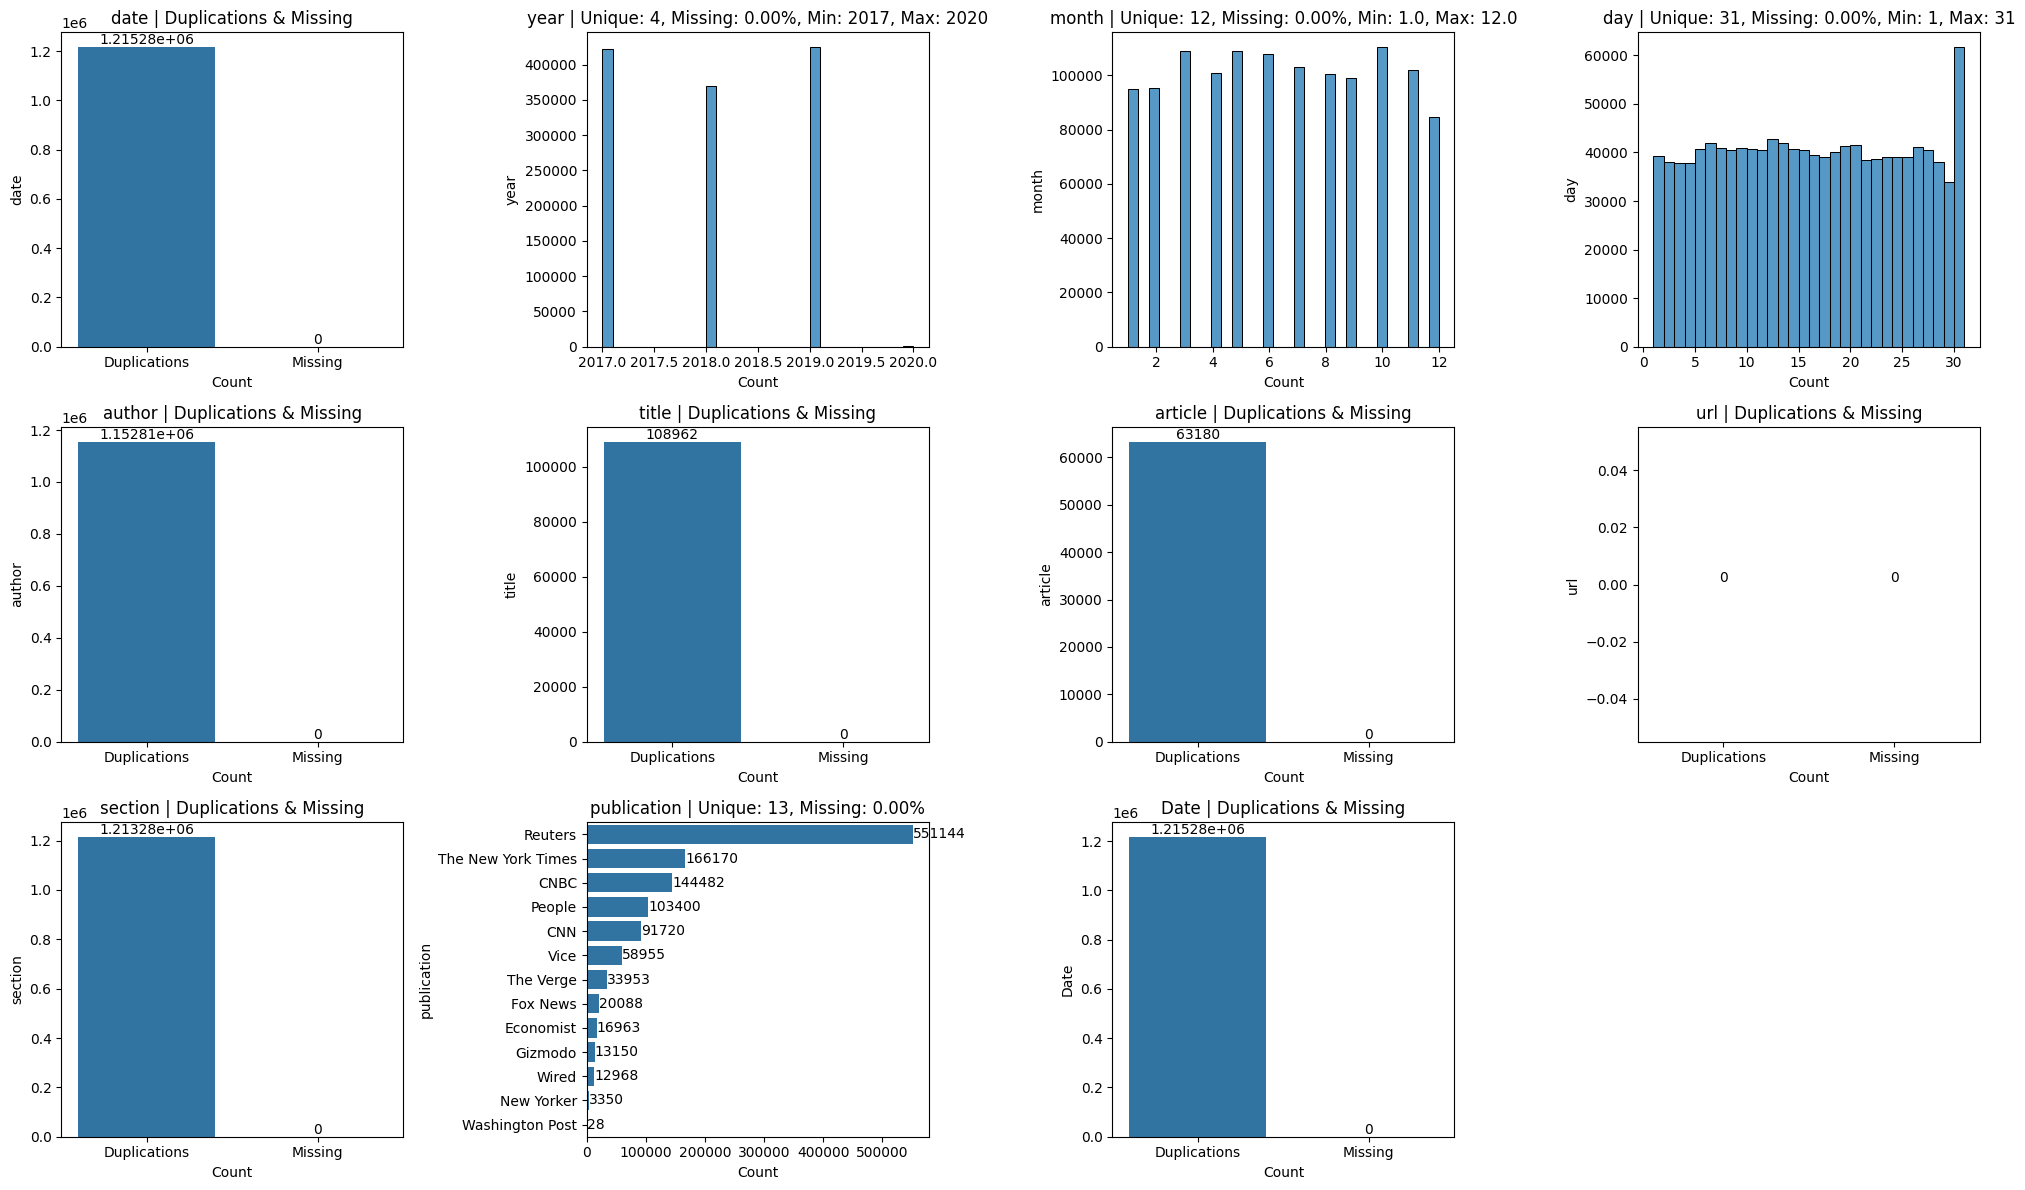

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Unified plotting function
def plot_columns(data):
    num_cols = len(data.columns)
    rows = (num_cols // 4) + (num_cols % 4 > 0)  # Create enough rows for 5 columns per row
    fig, axes = plt.subplots(rows, 4, figsize=(20, 12))
    axes = axes.flatten()
    
    for i, column in enumerate(data.columns):
        unique = data[column].nunique()
        missing = data[column].isnull().mean() * 100
        
        ax = axes[i]
        if pd.api.types.is_numeric_dtype(data[column]):
            sns.histplot(data[column].dropna(), kde=False, bins=30, ax=ax)
            ax.set_title(f"{column} | Unique: {unique}, Missing: {missing:.2f}%, Min: {data[column].min()}, Max: {data[column].max()}")
        elif column in ["publication"]:
            plot = sns.countplot(y=data[column], order=data[column].value_counts().index, ax=ax)
            plot.bar_label(plot.containers[0])
            ax.set_title(f"{column} | Unique: {unique}, Missing: {missing:.2f}%")
        else:
            dupes, nulls = data.duplicated(subset=[column]).sum(), data[column].isnull().sum()
            plot = sns.barplot(x=["Duplications", "Missing"], y=[dupes, nulls], ax=ax)
            plot.bar_label(plot.containers[0])
            ax.set_title(f"{column} | Duplications & Missing")
        ax.set_ylabel(column)
        ax.set_xlabel("Count")
        
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])  # Remove unused subplots
    
    plt.tight_layout()
    plt.show()

# Execute plotting
plot_columns(filtered_news)

#Duplicate Analysis & Visualization

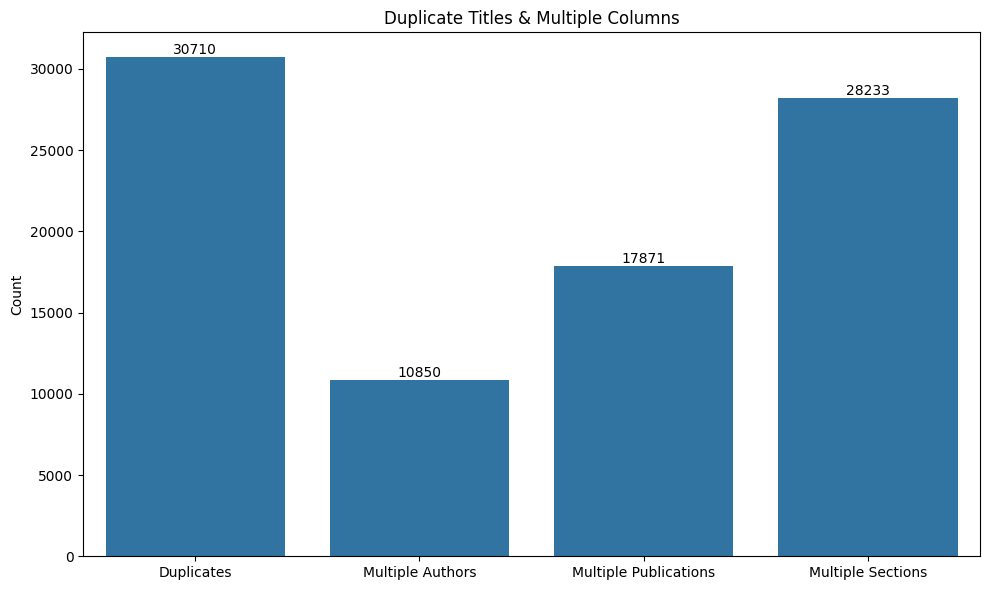

In [6]:
# Find duplicates based on title
duplicates = filtered_news[filtered_news.duplicated(subset='title', keep=False)]

# Group duplicates by title
grouped_duplicates = duplicates.groupby('title')

# Dictionary to hold details of duplicates
duplicate_details = {}

for title, group in grouped_duplicates:
    unique_publications = group['publication'].nunique()
    unique_dates = group['Date'].nunique()
    unique_authors = group['author'].nunique()
    unique_sections = group['section'].nunique()

    if unique_publications > 1 or unique_dates > 1 or unique_authors > 1 or unique_sections > 1:
        duplicate_details[title] = group

# Count the number of different duplicates
duplicates_count = len(duplicate_details)
multiple_authors = sum(group['author'].nunique() > 1 for group in duplicate_details.values())
multiple_publications = sum(group['publication'].nunique() > 1 for group in duplicate_details.values())
multiple_sections = sum(group['section'].nunique() > 1 for group in duplicate_details.values())

# Plot duplicate statistics
plt.figure(figsize=(10, 6))
plot = sns.barplot(x=["Duplicates", "Multiple Authors", "Multiple Publications", "Multiple Sections"],
                   y=[duplicates_count, multiple_authors, multiple_publications, multiple_sections])
plot.bar_label(plot.containers[0])
plt.title("Duplicate Titles & Multiple Columns")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

#Data Cleaning

In [ ]:
# Remove the duplicates by missing by policy provided above
before = len(filtered_news)

# MISSING VALUES 
# Remove the rows with missing values unless the column is an author or section
filtered_news = filtered_news.dropna(subset=['title', 'article', 'Date'])

# Remove the duplicate rows
filtered_news = filtered_news.drop_duplicates()

# Remove the duplicates from the filtered news dataset based on the title column and keep the first occurrence 
filtered_news = filtered_news.drop_duplicates(subset='title', keep='first')

# Now that we have found and removed all the duplicates, we can remove unnecessary columns, i.e., ones that will not be used in the analysis
filtered_news = filtered_news.drop(columns=['year', 'author', 'url', 'section', 'publication'])

after = len(filtered_news)

print(f"We have deleted {before - after} rows and we currently have {after} rows in our DataFrame")

We have deleted 108962 rows and we currently have 1107409 rows in our DataFrame


In [ ]:
import gc

# Create a separation of the dataset for further processing
filtered_news_addr = {}

# Loop over each year using a for loop
for year in range(2010, 2021):
    # Define the file path and date range for the year
    filtered_news_file_path = f"C:/Users/argam/Documents/GitHub/FinTrendLSTM/data/filtered_news{year}.csv"
    filtered_news_addr[year] = filtered_news_file_path
    
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"
    
    # Filter the data for the specified date range
    data = filtered_news.loc[(filtered_news['Date'] >= start_date) & (filtered_news['Date'] <= end_date)]
    
    # Save the filtered data to CSV
    data.to_csv(filtered_news_file_path, index=False)
    
    # Free up memory by deleting the 'data' DataFrame
    del data

# Optionally, free up memory used by the original DataFrame if it's no longer needed
del filtered_news
gc.collect()


#Financial News Filtering

In [ ]:
# Define financial keywords
keywords = [
        'AAPL', 'Apple', 'Apple Inc.', 'iPhone', 'MacBook', 'iPad', 'Apple stock',
        'AMZN', 'Amazon', 'Amazon Inc.', 'AWS', 'Prime', 'Amazon stock'
        'NFLX', 'Netflix', 'Netflix Originals', 'Streaming', 'Netflix stock'
        'stock', 'stocks', 'shares', 'equity', 'price movement', 'market trends',
        'bull market', 'bear market', 'market volatility', 'earnings report',
        'quarterly results', 'forecast', 'valuation', 'trading volume', 'short squeeze',
        'revenue', 'profits', 'losses', 'dividends', 'growth', 'inflation',
        'recession', 'GDP', 'interest rates', 'policy changes'
]

# Create a regex pattern
keyword_pattern = '|'.join(keywords)

for year, address in filtered_news_addr:
    filtered_news = pd.read_csv(address,low_memory=False)
        
    # Filter articles based on keywords
    filtered_news = filtered_news[
        filtered_news['title'].str.contains(keyword_pattern, case=False, na=False) |
        filtered_news['article'].str.contains(keyword_pattern, case=False, na=False)
    ]

    # Further refine by ensuring both title and article contain financial terms
    filtered_news = filtered_news[
        (filtered_news['title'].str.contains(keyword_pattern, case=False, na=False)) &
        (filtered_news['article'].str.contains(keyword_pattern, case=False, na=False))
    ]

    filtered_news.to_csv(address, Index=False)
    print_head(filtered_news)
    del filtered_news
    gc.collect()

           date  month  day               title             article       Date
45   2019-07-04    7.0    4  S.Korean stocks...  * KOSPI index c... 2019-07-04
51   2019-03-24    3.0   24  U.S. Treasury y...  NEW YORK (Reute... 2019-03-24
54   2019-03-27    3.0   27  U.S. current ac...  WASHINGTON (Reu... 2019-03-27
67   2019-06-25    6.0   25  UPS will not jo...  (Reuters) - Uni... 2019-06-25
85   2019-06-20    6.0   20  U.S. efforts to...  WASHINGTON (Reu... 2019-06-20
120  2018-04-17    4.0   17  China posts str...  BEIJING (Reuter... 2018-04-17
122  2019-04-05    4.0    5  Supreme Court r...  (Reuters) - The... 2019-04-05
131  2019-06-28    6.0   28  U.S. consumer s...  WASHINGTON (Reu... 2019-06-28
180  2017-05-18    5.0   18  Chief Keef Coul...  Chief Keef's in... 2017-05-18
191  2019-06-27    6.0   27  Hong Kong share...  * Hang Seng ind... 2019-06-27


# creating a finanacial only dataset

In [ ]:
# Define keyword groups for categorization
keywords = {
    'AAPL': ['AAPL', 'Apple', 'Apple Inc.', 'iPhone', 'MacBook', 'iPad', 'Apple stock'],
    'AMZN': ['AMZN', 'Amazon', 'Amazon Inc.', 'AWS', 'Prime', 'Amazon stock'],
    'NFLX': ['NFLX', 'Netflix', 'Netflix Originals', 'Streaming', 'Netflix stock'],
    'General': [
        'stock', 'stocks', 'shares', 'equity', 'price movement', 'market trends',
        'bull market', 'bear market', 'market volatility', 'earnings report',
        'quarterly results', 'forecast', 'valuation', 'trading volume', 'short squeeze',
        'revenue', 'profits', 'losses', 'dividends', 'growth', 'inflation',
        'recession', 'GDP', 'interest rates', 'policy changes'
    ]
}

# Function to categorize articles based on prioritization
def categorize_article(row):
    # Combine 'title' and 'article' for comprehensive keyword matching
    title = row['title'].lower() if isinstance(row['title'], str) else ''
    article = row['article'].lower() if isinstance(row['article'], str) else ''

    # Check title first
    for group, group_keywords in keywords.items():
        if any(keyword.lower() in title for keyword in group_keywords):
            # Return the first matching group unless it is 'General'
            if group != 'General':
                return group

    # If no match in title, check article
    for group, group_keywords in keywords.items():
        if any(keyword.lower() in article for keyword in group_keywords):
            return group

    # Default to 'General' if no match
    return 'General'

for year, address in filtered_news_addr:
    filtered_news = pd.read_csv(address,low_memory=False)
    
    # Initialize a 'Ticker' column with a default value of 'General'
    filtered_news['Ticker'] = 'General'
    # Apply the categorization function to each row
    filtered_news['Ticker'] = filtered_news.apply(categorize_article, axis=1)    
    

    filtered_news.to_csv(address, Index=False)
    print_head(filtered_news)
    del filtered_news
    gc.collect()



#Stock Market & News Frequency Analysis

Columns in filtered_news: Index(['date', 'month', 'day', 'title', 'article', 'Date', 'Ticker'], dtype='object')
First few rows:
          date  month  day                                              title  \
45 2019-07-04    7.0    4  S.Korean stocks snap 4-day losing streak as U....   
51 2019-03-24    3.0   24  U.S. Treasury yields hit lowest since late 201...   
54 2019-03-27    3.0   27  U.S. current account deficit hits 10-year high...   
67 2019-06-25    6.0   25  UPS will not join FedEx lawsuit against U.S. g...   
85 2019-06-20    6.0   20  U.S. efforts to cut off Iran oil revenue worki...   

                                              article       Date   Ticker  
45  * KOSPI index climbs, foreigners net buyers  *... 2019-07-04  General  
51  NEW YORK (Reuters) - Benchmark U.S. Treasury d... 2019-03-24     AAPL  
54  WASHINGTON (Reuters) - The U.S. current accoun... 2019-03-27  General  
67  (Reuters) - United Parcel Service Inc said on ... 2019-06-25     AMZN  
85  WASHIN

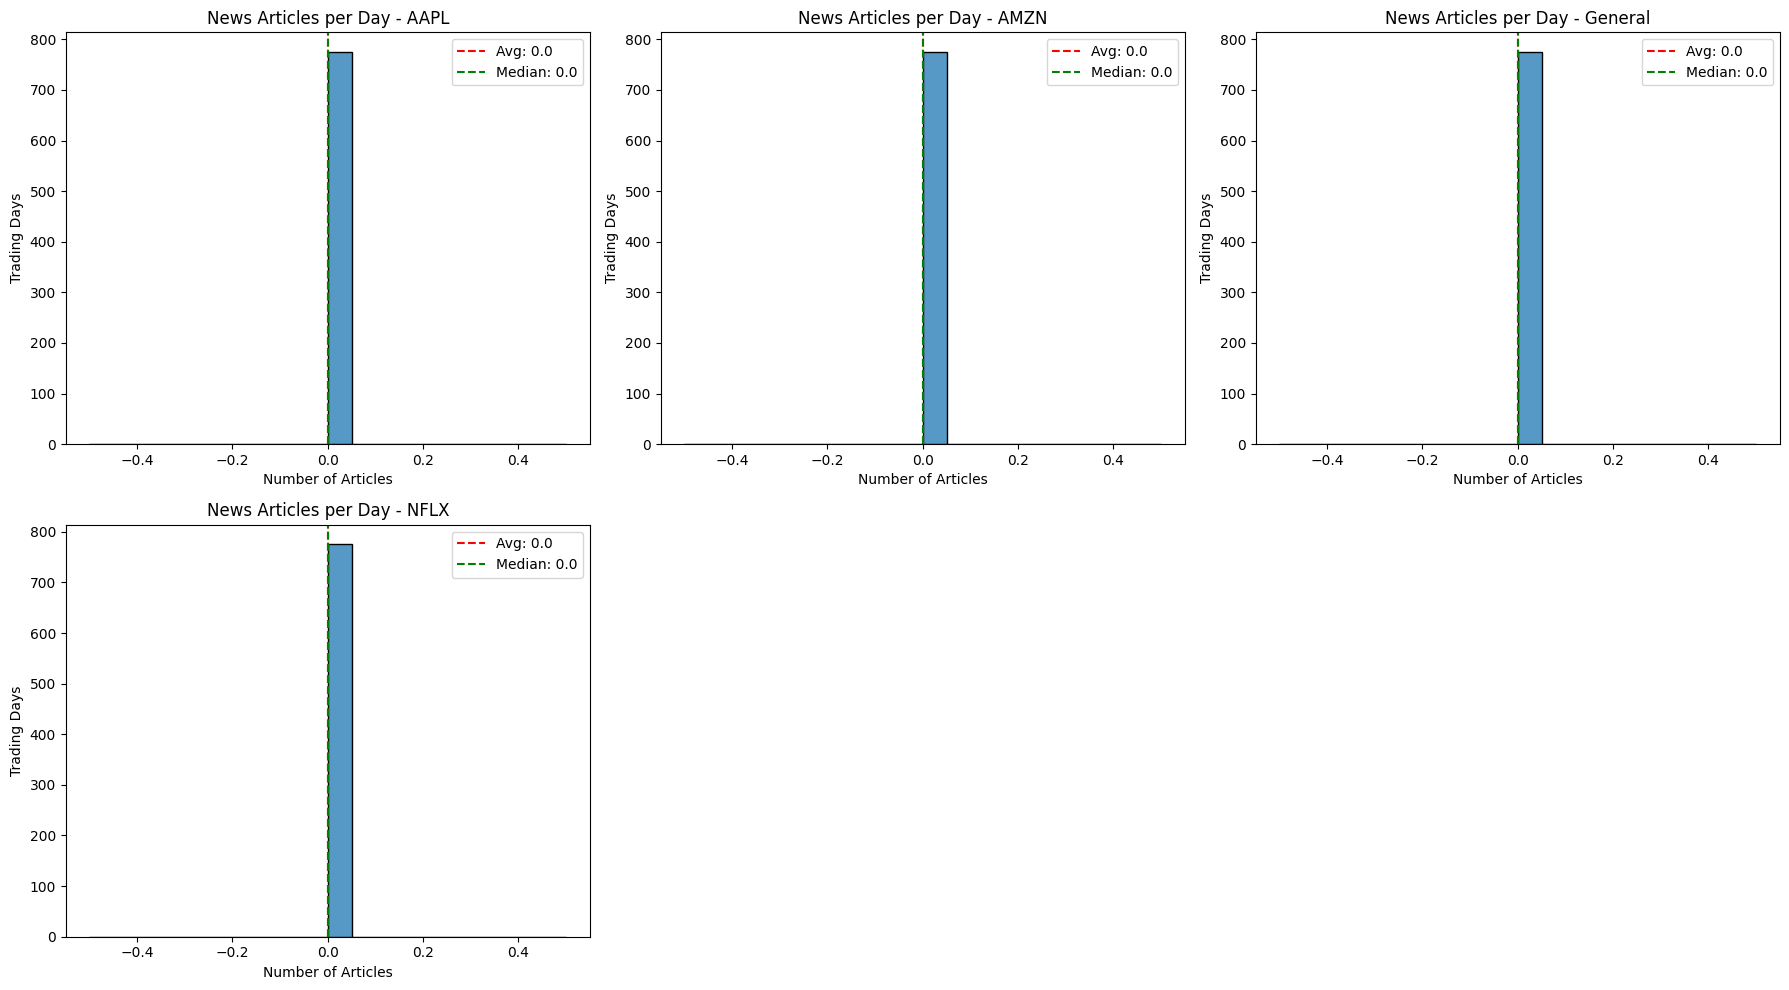

In [ ]:
import pandas as pd
import pandas_market_calendars as mcal
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gc

# Define the NYSE calendar
nyse = mcal.get_calendar('NYSE')

for year, address in filtered_news_addr.items():  # Fix: Correct dictionary unpacking
    filtered_news = pd.read_csv(address, low_memory=False)

    # Define date range
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"

    # Convert date column to datetime format
    filtered_news['date'] = pd.to_datetime(filtered_news['date'])

    print("Columns in filtered_news:", filtered_news.columns)
    print("First few rows:\n", filtered_news.head())  # Fix: Removed undefined function print_head()

    # Group by date and ticker to count articles per day per stock
    news_counts_per_stock = filtered_news.groupby(['date', 'Ticker']).size().unstack(fill_value=0)

    # Get valid trading days
    trading_days = pd.to_datetime(nyse.valid_days(start_date=start_date, end_date=end_date))

    # Ensure all stocks have counts for all trading days (fill missing with 0)
    news_counts_per_stock = news_counts_per_stock.reindex(trading_days, fill_value=0)

    # Calculate statistics
    stock_stats = news_counts_per_stock.describe().T  # Transpose for better readability

    # Get number of stocks
    unique_stocks = news_counts_per_stock.columns.tolist()
    num_stocks = len(unique_stocks)

    # Define subplot grid layout dynamically
    num_cols = min(num_stocks, 3)  # Maximum 3 columns
    num_rows = (num_stocks // 3) + (num_stocks % 3 > 0)  # Adjust number of rows
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(18, 5 * num_rows))
    
    # Flatten axes array safely
    axes = np.array(axes).flatten() if num_stocks > 1 else [axes]

    # Plot histogram for each stock
    for i, stock in enumerate(unique_stocks):
        ax = axes[i]
        sns.histplot(news_counts_per_stock[stock], bins=20, kde=False, ax=ax)
        
        # Add stats
        avg = news_counts_per_stock[stock].mean()
        median = news_counts_per_stock[stock].median()
        ax.axvline(avg, color='red', linestyle='--', label=f'Avg: {avg:.1f}')
        ax.axvline(median, color='green', linestyle='--', label=f'Median: {median:.1f}')
        
        # Labels and title
        ax.set_title(f"News Articles per Day - {stock}")
        ax.set_xlabel("Number of Articles")
        ax.set_ylabel("Trading Days")
        ax.legend()

    # Remove any unused subplots (if stocks are not a multiple of 3)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    # Save the processed DataFrame back to CSV
    filtered_news.to_csv(address, index=False)  # Fix: Corrected "Index=False" to "index=False"

    print(filtered_news.head())  # Fix: Removed undefined function print_head()
    
    # Clean up memory
    del filtered_news
    gc.collect()

# Saving subset for testin

In [11]:
import gc
import pandas as pd

if TEST:
    # Count news articles per stock per day
    news_counts = filtered_news.groupby(['Date', 'Ticker']).size().reset_index(name='count')

    # Find the minimum news count on any day across all stocks
    min_news_per_day = news_counts['count'].min()
    min_news_date = news_counts[news_counts['count'] == min_news_per_day]['Date'].unique()

    print(f"📉 Minimum number of news articles per stock per day: {min_news_per_day}")
    print(f"📅 This occurred on: {min_news_date}")

    # Count how many stock-days have fewer than this minimum
    below_min_count = (news_counts['count'] > min_news_per_day).sum()
    print(f"⚠️ Number of stock-days with more than {min_news_per_day} news articles: {below_min_count}")

    # Ensure at least 1 article per stock per day
    min_news_per_day = max(1, min_news_per_day)

    # Apply filtering:
    # - If a stock has ≤ 25 articles on a day, keep all.
    # - If a stock has > 25 articles on a day, randomly sample 25.
    filtered_news = filtered_news.groupby(['Date', 'Ticker']).sample(n=min_news_per_day, random_state=42)

 #   filtered_news = filtered_news.groupby(['Date', 'Ticker']).apply(lambda x: x.sample(n=min(len(x), 25), random_state=42)).reset_index(drop=True)

    # Free memory
    gc.collect()

### Categorizing Financial News Articles

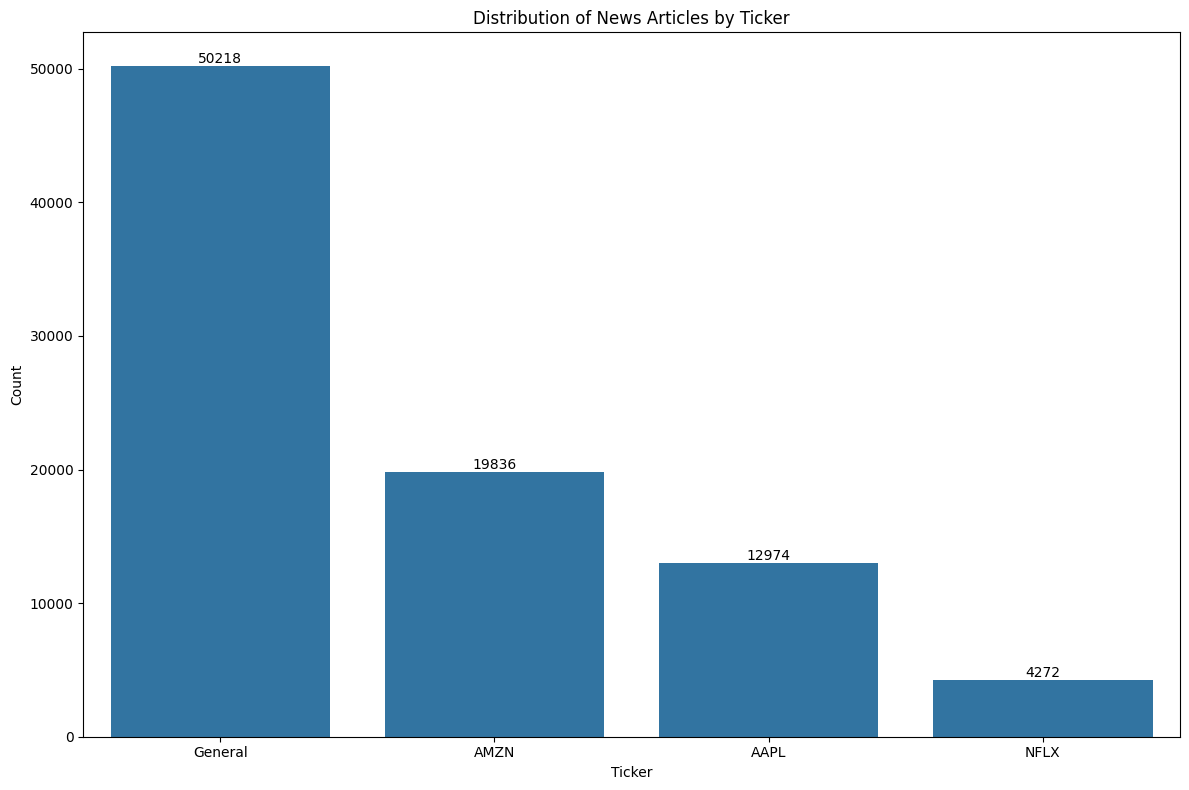

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Example dictionary of CSV file paths keyed by year
# filtered_news_addr = {2010: "path/to/filtered_news2010.csv", 2011: "path/to/filtered_news2011.csv", ... }

# Create a 4x3 grid for plotting (total 12 subplots)
fig, axes = plt.subplots(4, 3, figsize=(18, 24))
axes = axes.flatten()

# Iterate over each (year, file_path) pair
for i, (year, address) in enumerate(filtered_news_addr.items()):
    # Load the CSV for the current year
    filtered_news = pd.read_csv(address, low_memory=False)
    
    # Plot the countplot on the corresponding subplot
    ax = axes[i]
    order = filtered_news['Ticker'].value_counts().index
    plot = sns.countplot(ax=ax, x='Ticker', data=filtered_news, order=order)
    
    # Add bar labels to each container in the plot
    for container in ax.containers:
        ax.bar_label(container)
    
    # Set title and labels for clarity
    ax.set_title(f"News Articles Distribution for {year}")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("Count")
    
    # Optionally save each individual plot (if needed)
    fig_individual = plt.figure(figsize=(12, 8))
    ax_individual = fig_individual.add_subplot(111)
    sns.countplot(ax=ax_individual, x='Ticker', data=filtered_news, order=order)
    for container in ax_individual.containers:
        ax_individual.bar_label(container)
    ax_individual.set_title(f"News Articles Distribution for {year}")
    ax_individual.set_xlabel("Ticker")
    ax_individual.set_ylabel("Count")
    fig_individual.tight_layout()
    fig_individual.savefig(f"news_distribution_{year}.png")
    plt.close(fig_individual)
    
    # Clean up memory by deleting the DataFrame and collecting garbage
    del filtered_news
    gc.collect()

# If there are any unused axes (in case filtered_news_addr has fewer than 12 entries), remove them.
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and show the grid plot
plt.tight_layout()
plt.show()

# Save the grid of plots to a file
fig.savefig("news_distribution_grid.png")

# Text Normalization and Dimensionality Reduction in NLP

In [ ]:
from nltk.tokenize import word_tokenize , RegexpTokenizer

# Load data
if 'filtered_news' not in locals():
    filtered_news_file_path = "C:/Users/argam/Documents/GitHub/FinTrendLSTM/data/filtered_news.csv"
    filtered_news = pd.read_csv(filtered_news_file_path)

# Normalize text
def normalize_text(text):
    return re.sub(r'[^a-z\s]', '', text.lower())

filtered_news['title'] = filtered_news['title'].apply(normalize_text)
filtered_news['article'] = filtered_news['article'].apply(normalize_text)

# Tokenize text
filtered_news['title'] = filtered_news['title'].apply(word_tokenize)
filtered_news['article'] = filtered_news['article'].apply(word_tokenize)

# Define custom stop words
financial_stopwords = {
    'aapl', 'apple', 'amzn', 'amazon', 'nflx', 'netflix', 'stock', 'shares',
    'market', 'growth', 'earnings', 'trading', 'revenue', 'profit', 'economy',
    'price', 'forecast', 'volatility', 'dividends', 'inflation', 'gdp',
    'interest', 'valuation'
}

general_stopwords = set(stopwords.words('english'))
all_stopwords = general_stopwords - financial_stopwords

# Remove stop words
def remove_stopwords(tokens):
    return [word for word in tokens if word not in all_stopwords]

filtered_news['article'] = filtered_news['article'].apply(remove_stopwords)

# Lemmatize text
lemmatizer = nltk.WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

filtered_news['article'] = filtered_news['article'].apply(lemmatize_tokens)

filtered_news.to_csv(filtered_news_file_path, index=False)
# Generate word clouds
def generate_wordcloud(text, title, ax):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(title)

all_titles = ' '.join([' '.join(tokens) for tokens in filtered_news['title']])
all_articles = ' '.join([' '.join(tokens) for tokens in filtered_news['article']])

fig, axs = plt.subplots(1, 2, figsize=(24, 12))

generate_wordcloud(all_titles, "Title Word Cloud", axs[0])
generate_wordcloud(all_articles, "Article Word Cloud", axs[1])

# Add space between the subplots
fig.subplots_adjust(wspace=0.5)

plt.tight_layout()
plt.show()



NameError: name 'filtered_news' is not defined

### Word Cloud Visualization

A word cloud is a visual representation of text data, where the size of each word indicates its frequency or importance within the dataset. In this context, word clouds are generated from the titles and articles of financial news to highlight the most common terms. By normalizing, tokenizing, and lemmatizing the text, and removing stop words, the resulting word clouds provide a clear and concise overview of the key topics and trends in the financial news. This visualization technique is particularly useful for quickly identifying prominent themes and gaining insights into the overall sentiment and focus of the news articles.

# Unique data frames cration

In [1]:
# creat 3 dataframes for rach preprocesse strategy of the textual data POS | Bi-grams and Tri-grams | Word Embeddings
# Create a dictionary to hold all preprocessed news dataframes
news_dataframes = {}

# Names of different preprocessing strategies
names = ['pos', 'bigrams', 'word_embeddings']

# Initialize separate copies for each preprocessing method
for name in names:
    news_dataframes[name] = filtered_news.copy()

# Now you can access each individual dataframe
pos_news = news_dataframes['pos']
bigrams_news = news_dataframes['bigrams']
word_embeddings_news = news_dataframes['word_embeddings']


NameError: name 'filtered_news' is not defined

# Part-of-speech (POS) labeling:

In [ ]:
# Define a function to perform POS tagging
def pos_tagging(tokens):
    return nltk.pos_tag(tokens)

# Apply POS tagging to the 'article' column
pos_news['article'] = pos_news['article'].apply(pos_tagging)
pos_news['title'] = pos_news['title'].apply(pos_tagging)


# N-grams

In [ ]:
# Handling Bi-grams and Tri-grams
# Define a function to generate n-grams
def generate_ngrams(tokens, n=2):
    return list(nltk.ngrams(tokens, n))

# Apply n-gram generation to the 'article' column
bigrams_news['article'] = bigrams_news['article'].apply(generate_ngrams)
bigrams_news['title'] = bigrams_news['title'].apply(generate_ngrams)

fg

# Advanced Dimensionality Reduction Techniques in NLP: Word Embedding

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from transformers import AutoTokenizer, AutoModel

# **Check if GPU is available**
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Using device: {device}")

# **Load FinBERT Model & Tokenizer**
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
finbert_model = AutoModel.from_pretrained("yiyanghkust/finbert-tone").to(device)
finbert_model.eval()  # Set to evaluation mode

# **Preprocessing Function**
def preprocess_text(text):
    if isinstance(text, list):  # If column contains lists of tokens
        text = " ".join(text)  # Convert list to string
    return text.strip()

# **Function to generate FinBERT sentence embeddings**
def generate_finbert_embeddings(text):
    if not isinstance(text, str) or text.strip() == "":
        return np.zeros(768)  # FinBERT outputs 768-dimensional embeddings

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)

    with torch.no_grad():
        outputs = finbert_model(**inputs)
        embeddings = outputs.last_hidden_state[:, 0, :]  # Extract CLS token embedding

    return embeddings.squeeze().cpu().numpy()

output_path = "C:/Users/argam/Documents/GitHub/FinTrendLSTM/data/filtered_news_with_finbert_embeddings.csv"
if IMPORT_FILES : 
    word_embeddings_news = pd.read_csv(output_path)
else:
    # **Initialize tqdm progress bar for pandas**
    tqdm.pandas()

    # **Preprocess articles and titles**
    word_embeddings_news['article'] = word_embeddings_news['article'].apply(preprocess_text)
    word_embeddings_news['title'] = word_embeddings_news['title'].apply(preprocess_text)

    # **Generate FinBERT Embeddings**
    word_embeddings_news['article_embeddings'] = word_embeddings_news['article'].progress_apply(generate_finbert_embeddings)
    word_embeddings_news['title_embeddings'] = word_embeddings_news['title'].progress_apply(generate_finbert_embeddings)

    # **Save the Updated DataFrame**
    word_embeddings_news.to_csv(output_path, index=False)



✅ Using device: cpu


100%|██████████| 4111/4111 [05:33<00:00, 12.33it/s]


#Plot the embeddings

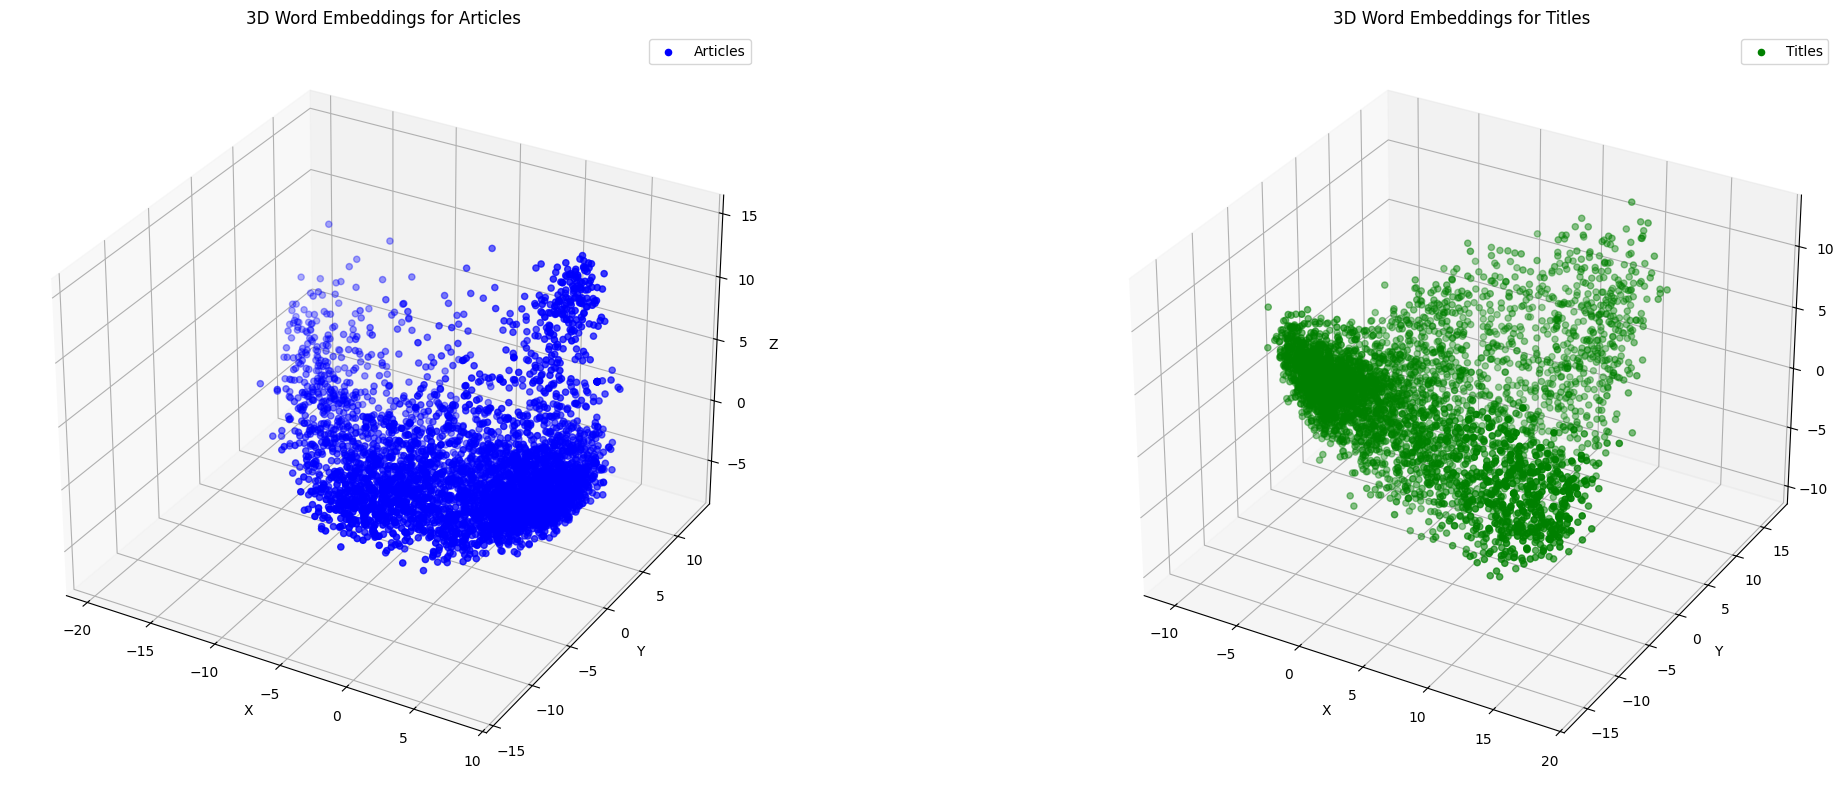

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Prepare the embeddings for PCA
article_embeddings = np.array(word_embeddings_news['article_embeddings'].tolist())
title_embeddings = np.array(word_embeddings_news['title_embeddings'].tolist())

# Reduce dimensions using PCA
article_embeddings_3d = PCA(n_components=3).fit_transform(article_embeddings)
title_embeddings_3d = PCA(n_components=3).fit_transform(title_embeddings)

# Create a 1x2 grid for the plots
fig, axs = plt.subplots(1, 2, figsize=(24, 8), subplot_kw={'projection': '3d'})

# Plot 3D embeddings for articles
axs[0].scatter(article_embeddings_3d[:, 0], article_embeddings_3d[:, 1], article_embeddings_3d[:, 2], color='blue', label='Articles')
axs[0].set_title("3D Word Embeddings for Articles")
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_zlabel("Z")
axs[0].legend()

# Plot 3D embeddings for titles
axs[1].scatter(title_embeddings_3d[:, 0], title_embeddings_3d[:, 1], title_embeddings_3d[:, 2], color='green', label='Titles')
axs[1].set_title("3D Word Embeddings for Titles")
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
axs[1].set_zlabel("Z")
axs[1].legend()

plt.tight_layout()
plt.show()

#FinBERT model to calculate sentiment scores

In [ ]:
import numpy as np
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# **Check for GPU availability and exit if not available**
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Using device: {device}")

# **Load FinBERT model and tokenizer (only once)**
tokenizer = BertTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = BertForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone").to(device)
model.eval()  # Set to evaluation mode (no gradient updates)

def calculate_sentiment_with_finbert(data, column, preprocessed='pos', batch_size=32):
    """
    Use the FinBERT model to calculate sentiment scores for financial news articles.
    Supports batching for faster processing.

    :param data: Pandas DataFrame
    :param column: Column name containing text or embeddings
    :param preprocessed: Preprocessing type ('pos', 'bigrams', or 'word_embeddings')
    :param batch_size: Number of samples per batch for efficiency
    :return: DataFrame with new sentiment score column
    """

    scores = []

    # **Prepare text based on preprocessing type**
    if preprocessed == 'pos':
        texts = [' '.join([f"{word}/{tag}" for word, tag in tokens]) for tokens in data[column]]
    elif preprocessed == 'bigrams':
        texts = [' '.join(['_'.join(bigram) for bigram in tokens]) for tokens in data[column]]
    elif preprocessed == 'word_embeddings':
        texts = [' '.join(tokens) for tokens in data[column]]
    else:
        raise ValueError("Invalid preprocessed option. Use 'pos', 'bigrams', or 'word_embeddings'.")

    # **Process texts in batches**
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]

        inputs = tokenizer(
            batch_texts,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=512
        ).to(device)  # Move inputs to GPU if available

        # **Inference without gradient calculation**
        with torch.no_grad():
            outputs = model(**inputs)
            sentiments = torch.nn.functional.softmax(outputs.logits, dim=-1)
            sentiment_scores = sentiments[:, 1].cpu().tolist()  # Extract positive sentiment score
            scores.extend(sentiment_scores)

    # **Add scores to DataFrame**
    column_name = f"{column}_score"
    data[column_name] = scores
    return data

    # Free memory
    gc.collect()

✅ Using device: cpu


In [ ]:
# import os
# import gc
# import torch
# import torch.nn.functional as F
# from transformers import BertTokenizer, BertForSequenceClassification
# import pandas as pd

# # Check for GPU availability
# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(f"✅ Using device: {device}")

# # Load FinBERT model and tokenizer (only once)
# tokenizer = BertTokenizer.from_pretrained("yiyanghkust/finbert-tone")
# model = BertForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone").to(device)
# model.eval()  # Set to evaluation mode (no gradient updates)

# def calculate_sentiment_with_finbert(data, column, preprocessed='pos', batch_size=32, temp_dir="temp_batches"):
#     """
#     Processes the DataFrame in batches to calculate sentiment scores using FinBERT,
#     saves each batch result to CSV to free memory, and finally concatenates all batches.

#     :param data: Pandas DataFrame.
#     :param column: Column name containing text.
#     :param preprocessed: Preprocessing type ('pos', 'bigrams', or 'word_embeddings').
#     :param batch_size: Number of samples per batch.
#     :param temp_dir: Temporary directory for saving batch CSVs.
#     :return: DataFrame with a new sentiment score column.
#     """
#     # Ensure temporary directory exists
#     if not os.path.exists(temp_dir):
#         os.makedirs(temp_dir)
    
#     # Prepare the texts from the specified column based on preprocessed type
#     if preprocessed == 'pos':
#         texts = [' '.join([f"{word}/{tag}" for word, tag in tokens]) for tokens in data[column]]
#     elif preprocessed == 'bigrams':
#         texts = [' '.join(['_'.join(bigram) for bigram in tokens]) for tokens in data[column]]
#     elif preprocessed == 'word_embeddings':
#         texts = [' '.join(tokens) for tokens in data[column]]
#     else:
#         raise ValueError("Invalid preprocessed option. Use 'pos', 'bigrams', or 'word_embeddings'.")
    
#     total_samples = len(texts)
#     batch_files = []
    
#     for i in range(0, total_samples, batch_size):
#         print(f"Processing batch {i // batch_size + 1} / {((total_samples - 1) // batch_size) + 1}")
#         batch_texts = texts[i:i+batch_size]
        
#         # Tokenize the batch
#         inputs = tokenizer(
#             batch_texts,
#             return_tensors="pt",
#             truncation=True,
#             padding=True,
#             max_length=512
#         ).to(device)
        
#         # Inference
#         with torch.no_grad():
#             outputs = model(**inputs)
#             sentiments = F.softmax(outputs.logits, dim=-1)
#             # Extract positive sentiment score for each sample
#             sentiment_scores = sentiments[:, 1].cpu().tolist()
        
#         # Create a DataFrame for this batch
#         batch_df = data.iloc[i:i+batch_size].copy()
#         batch_df[f"{column}_score"] = sentiment_scores
        
#         # Save batch to a CSV file
#         batch_file = os.path.join(temp_dir, f"batch_{i//batch_size}.csv")
#         batch_df.to_csv(batch_file, index=False)
#         batch_files.append(batch_file)
        
#         # Free memory for this batch
#         del inputs, outputs, sentiments, sentiment_scores, batch_df, batch_texts
#         gc.collect()
    
#     # After processing all batches, load each CSV and concatenate
#     print("Concatenating batch files...")
#     df_list = [pd.read_csv(f) for f in batch_files]
#     final_df = pd.concat(df_list, ignore_index=True)
    
#     # Clean up temporary batch files
#     for f in batch_files:
#         os.remove(f)
#     os.rmdir(temp_dir)
    
#     # Clean up memory
#     del df_list, batch_files
#     gc.collect()
    
#     return final_df

# # Example usage:
# # data = pd.read_csv("your_input.csv")  # Load your DataFrame
# # data_with_sentiment = calculate_sentiment_with_finbert(data, column="article", preprocessed="pos", batch_size=128)
# # data_with_sentiment.to_csv("final_with_sentiment.csv", index=False)


✅ Using device: cpu


# Calculate sentiment scores for each DataFrame


In [ ]:
# Calculate sentiment scores for each DataFrame
for name, data in news_dataframes.items():
  file_path = f"C:/Users/argam/Documents/GitHub/FinTrendLSTM/data/test_{name}_news_with_sentiment.csv"
  if IMPORT_FILES :
    data = pd.read_csv(file_path)
  else : 
    data = calculate_sentiment_with_finbert(data = data, column = 'article', preprocessed = name , batch_size = 128)
    data = calculate_sentiment_with_finbert(data = data, column = 'title', preprocessed = name , batch_size = 128)
    data.to_csv(file_path, index=False)



#Financial data

In [ ]:
# import os

# # Define the list of stock symbols and date range
# stocks = ["AAPL", "AMZN", "NFLX"]
# start_date = "2017-01-01"
# end_date = "2020-01-01"
stock_data_path = "C:/Users/argam/Documents/GitHub/FinTrendLSTM/data"

# # Add a directory to save the dataframes
# data_frames = {}

# # Ensure the save path exist
# os.makedirs(stock_data_path, exist_ok=True)

# # Loop through the stocks and download the data
# for stock in stocks:
#     data = yf.download(stock, start=start_date, end=end_date)

#     # Reset the index to make Date a column
#     data.reset_index(inplace=True)

#     # Add the Ticker column
#     data['Ticker'] = stock   

#     #print all the unfolded lyres of the dataframe loop ovrer data and unfold it
#     data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data.columns]

#     # rename the columns bu rmoving the everythign after the underscore including the underscore
#     data.columns = [col.split("_")[0] for col in data.columns]

#     # Keep only necessary columns
#     data = data[["Ticker", "Date", "Open", "Close", "High", "Low", "Volume"]]

#     # Add the data to the dictionary
#     data_frames[stock] = data

#     # Save the data to a CSV file
#     file_path = os.path.join(stock_data_path, f"{stock}_stock_data.csv")
#     data.to_csv(file_path, index=False)
    
# # combine all the dataframes into a single dataframe
# for stock, data in data_frames.items():
#     if stock == stocks[0]:
#         all_data = data
#     else:
#         all_data = pd.concat([all_data, data], ignore_index=True, axis=0)

# # Save the combined data to a CSV file
all_data_file_path = os.path.join(stock_data_path, "all_stocks_data.csv")
# all_data.to_csv(all_data_file_path, index=False)

# Load the stock data
financial_data = pd.read_csv(all_data_file_path)

In [ ]:
import pandas as pd

# Function to calculate RSI
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)  

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

# Function to calculate SMA
def calculate_sma(data, window=14):
    return data.rolling(window=window, min_periods=1).mean()

# Function to calculate Stochastic Oscillator %K
def calculate_stochastic_oscillator(data, window=14):
    low_min = data['Low'].rolling(window=window, min_periods=1).min()
    high_max = data['High'].rolling(window=window, min_periods=1).max()
    stochastic_k = 100 * (data['Close'] - low_min) / (high_max - low_min)
    return stochastic_k

# Ensure each financial metric is calculated per stock ticker
financial_data['RSI'] = financial_data.groupby('Ticker')['Close'].transform(calculate_rsi)
financial_data['SMA'] = financial_data.groupby('Ticker')['Close'].transform(calculate_sma)

# Fix for Stochastic Oscillator %K to return a Series, avoiding the ValueError
financial_data['%K'] = financial_data.groupby('Ticker', group_keys=False)['Close'].transform(
    lambda x: calculate_stochastic_oscillator(financial_data.loc[x.index], window=14)
)

# Add trend features
financial_data['Today_Trend'] = financial_data['Close'] - financial_data['Open']

# ✅ **Fix: Correct `Class` Calculation for Regression**
financial_data['Class'] = financial_data.groupby('Ticker')['Close'].diff().shift(-1)

# ✅ **Fix: Normalize Prices**
financial_data['Close'] = financial_data.groupby('Ticker')['Close'].transform(lambda x: (x - x.mean()) / x.std())
financial_data['Open'] = financial_data.groupby('Ticker')['Open'].transform(lambda x: (x - x.mean()) / x.std())
financial_data['High'] = financial_data.groupby('Ticker')['High'].transform(lambda x: (x - x.mean()) / x.std())
financial_data['Low'] = financial_data.groupby('Ticker')['Low'].transform(lambda x: (x - x.mean()) / x.std())

# Debugging: Print min/max values
print(financial_data[['Close', 'Class']].describe())

# Display the first few rows
for col in financial_data.columns:
    print(f'{col} :', financial_data[col].min(), financial_data[col].max())

              Close        Class
count  2.262000e+03  2259.000000
mean   1.256486e-16     0.130661
std    9.995576e-01     4.073386
min   -1.934907e+00   -37.230011
25%   -9.134434e-01    -0.587498
50%    1.595870e-01     0.082500
75%    8.044436e-01     0.775000
max    3.223072e+00    28.279999
Ticker : AAPL NFLX
Date : 2017-01-03 2019-12-31
Open : -1.9435153396133986 3.1643116577187205
Close : -1.9349073723632662 3.2230719458577015
High : -1.9536126427904301 3.1663689987302974
Low : -1.9468952854748907 3.1884473893879997
Volume : 2019300 447940000
RSI : 0.0 100.0
SMA : 29.021249771118164 402.5878601074219
%K : 0.0 100.0
Today_Trend : -30.45001220703125 32.529998779296875
Class : -37.23001098632818 28.279998779296818


In [ ]:
# Normalize function to scale 0 to 1
def normalize_zero(column):
    return (column - column.min()) / (column.max() - column.min())

# Normalize function to scale -1 to 1
def normalize_minus_one(column):
    return 2 * ((column - column.min()) / (column.max() - column.min())) - 1

# Columns that still need normalization
zero_normalized_columns = ['Volume', 'RSI', 'SMA', '%K']
minus_one_normalized_columns = ['Today_Trend']

# Apply normalization
for col in zero_normalized_columns:
    financial_data[col] = normalize_zero(financial_data[col])

for col in minus_one_normalized_columns:
    financial_data[col] = normalize_minus_one(financial_data[col])

# Debug print
print(financial_data[['Volume', 'RSI', 'SMA', '%K', 'Today_Trend']].describe())

            Volume          RSI          SMA           %K  Today_Trend
count  2262.000000  2259.000000  2262.000000  2262.000000  2262.000000
mean      0.155754     0.573201     0.268296     0.614183    -0.033426
std       0.135791     0.176007     0.298675     0.294033     0.111461
min       0.000000     0.000000     0.000000     0.000000    -1.000000
25%       0.018963     0.445853     0.048496     0.359989    -0.051707
50%       0.149240     0.572334     0.137047     0.677202    -0.032685
75%       0.230196     0.702641     0.413324     0.883361    -0.014358
max       1.000000     1.000000     1.000000     1.000000     1.000000


C:\Users\argam\AppData\Local\Temp\ipykernel_6448\942090174.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=financial_data, x='Ticker', y=col, ax=ax, palette=palette)
C:\Users\argam\AppData\Local\Temp\ipykernel_6448\942090174.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=financial_data, x='Ticker', y=col, ax=ax, palette=palette)
C:\Users\argam\AppData\Local\Temp\ipykernel_6448\942090174.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=financial_data, x='Ticker', y=col, ax=ax, palette=palette)
C:\Users\a

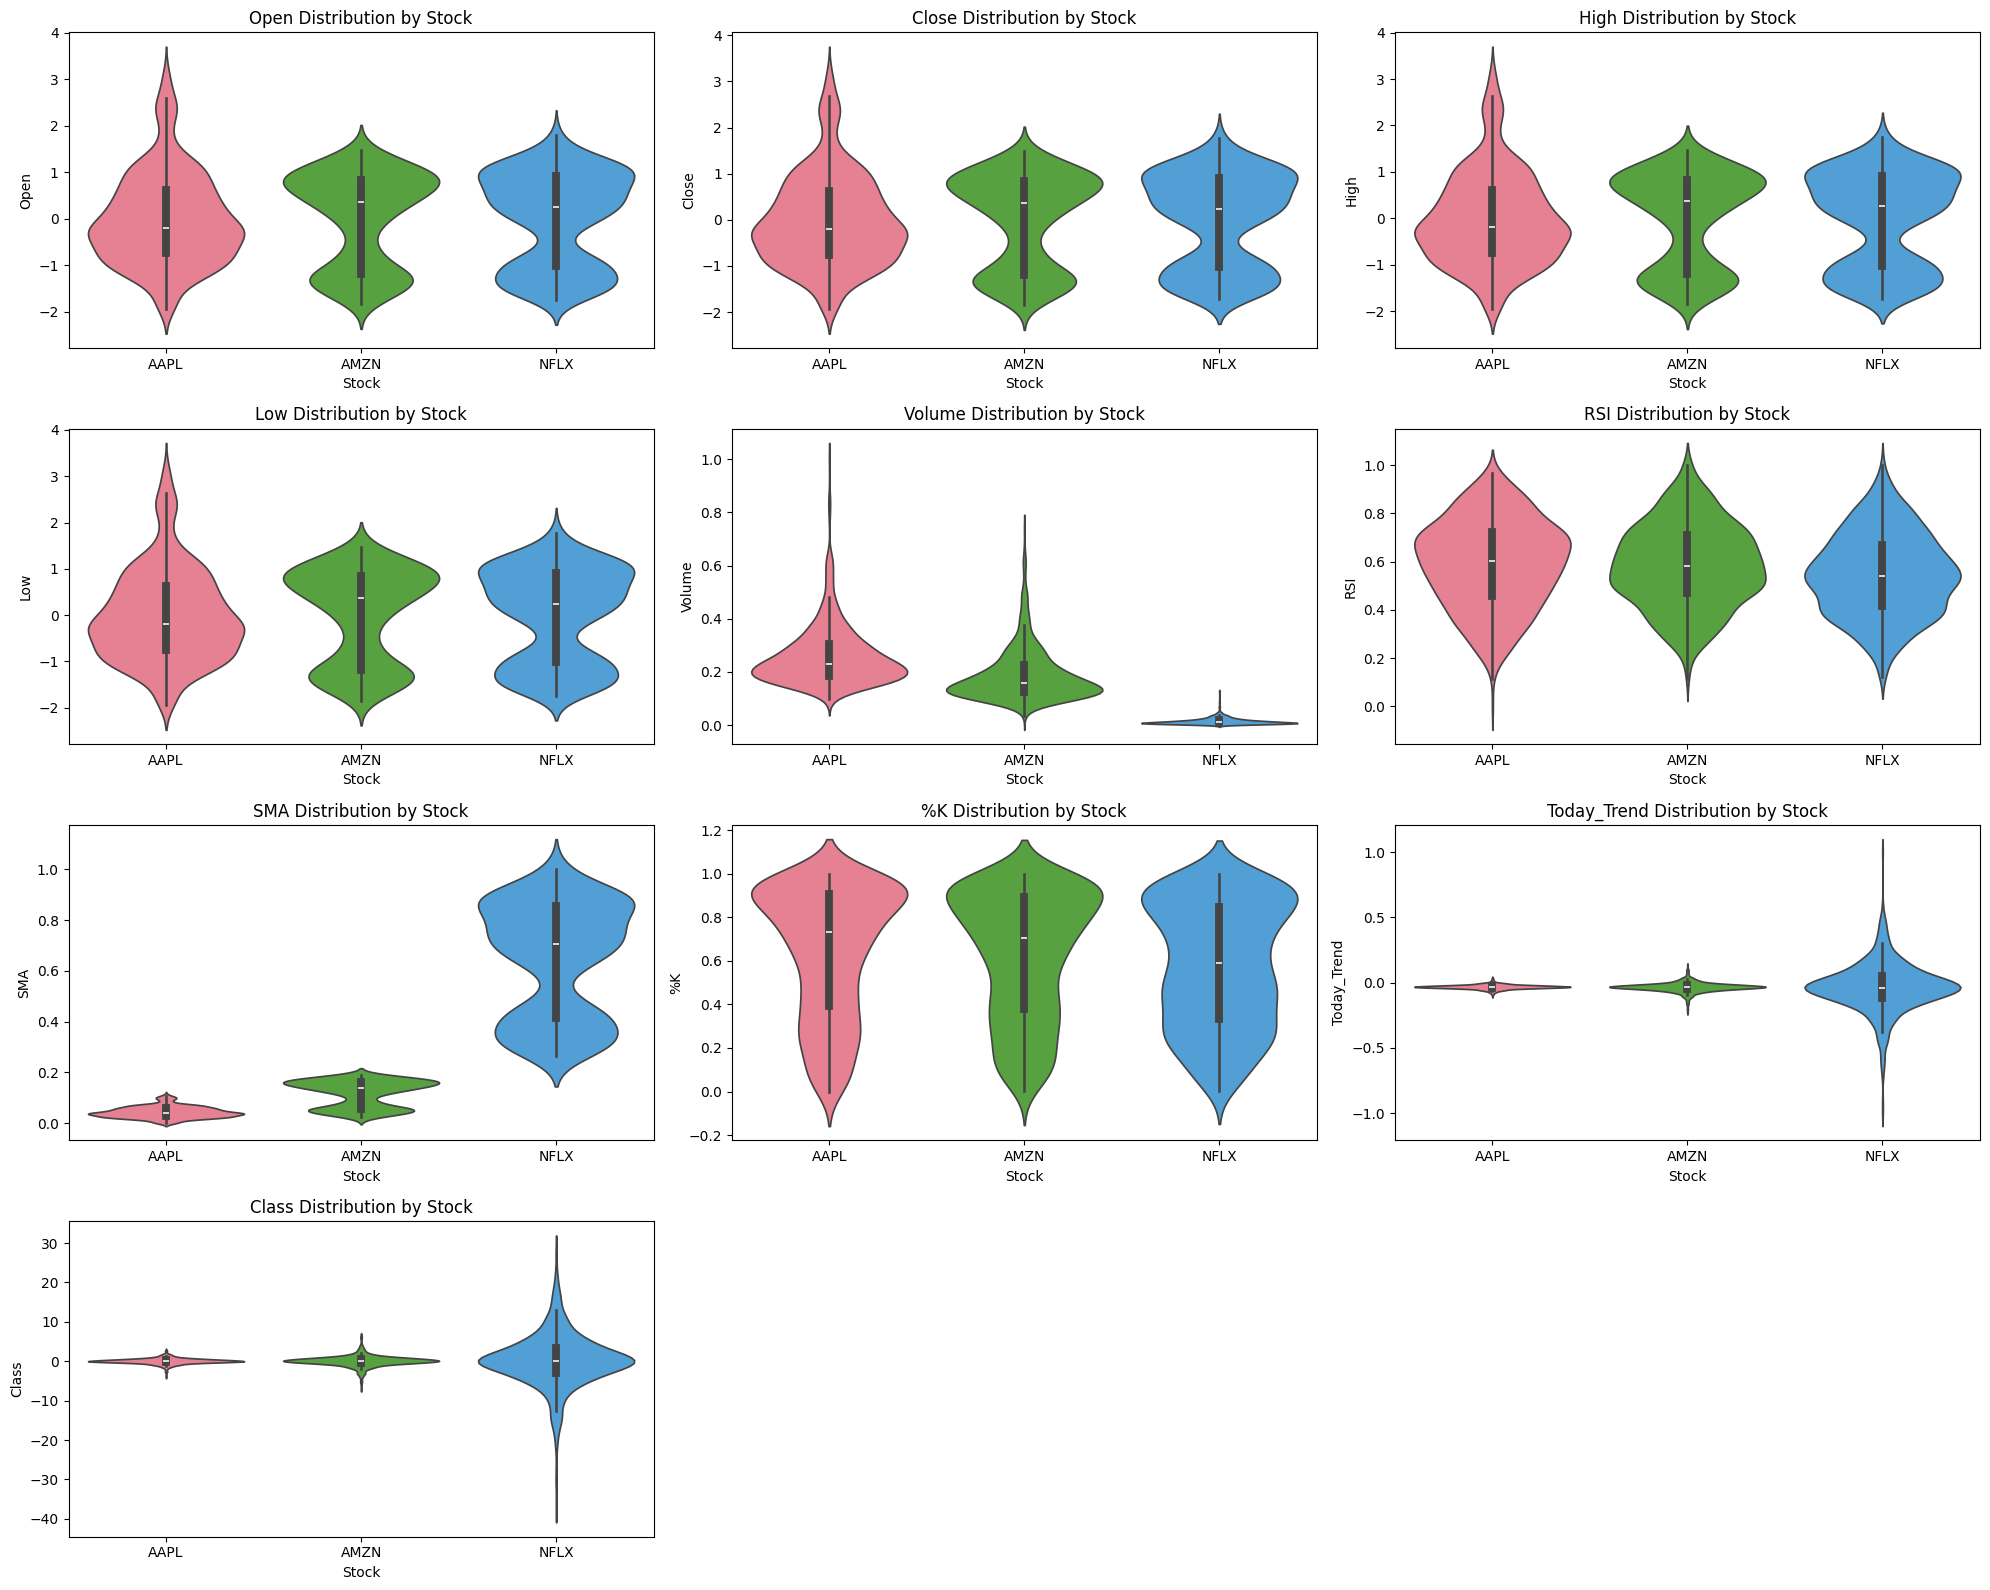

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Columns to plot (excluding Date and Ticker)
columns_to_plot = [col for col in financial_data.columns if col not in ['Date', 'Ticker']]
num_columns = 3  # 3 plots per row
num_rows = math.ceil(len(columns_to_plot) / num_columns)  # Auto-adjust rows

# Get unique tickers and assign each a color
unique_tickers = financial_data['Ticker'].unique()
palette = sns.color_palette("husl", len(unique_tickers))  # Generate unique colors

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(20, 4 * num_rows))
axes = axes.flatten()  # Flatten for easier indexing

# Generate violin plots
for i, col in enumerate(columns_to_plot):
    ax = axes[i]
    sns.violinplot(data=financial_data, x='Ticker', y=col, ax=ax, palette=palette)
    ax.set_title(f"{col} Distribution by Stock")
    ax.set_xlabel("Stock")
    ax.set_ylabel(col)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
# Combain the news and financial data
# First we will get one line per date per stock by taking the mean of the article and title scores
# Then we will merge the news and financial data on the date and stock ticker keeping only the financial data and 
# article and title scores
# we will save the new data frames in a dictionary so we will have a unique data frame for each preprocessed strategy
# at the moment we will not use the word embeddings as it is not clear how to combine the data
from sklearn.decomposition import PCA
# Define the mapping for news tickers to match financial data
ticker_mapping = {'APPLE': 'AAPL', 'AMAZON': 'AMZN', 'NETFLIX': 'NFLX'}

final_dataframes = {}
names = ['pos', 'bigrams', 'word_embeddings']

# Handle formatting issues
for name, data in news_dataframes.items():
    temp = data.copy() # Avoid modifying original data
    temp.rename(columns={'Date': 'Date', 'Ticker': 'Ticker'}, inplace=True)

    # Convert Date to datetime for consistency
    temp['Date'] = pd.to_datetime(temp['Date'])
    financial_data['Date'] = pd.to_datetime(financial_data['Date'])

    # Standardize Tickers (trim spaces, convert to uppercase)
    temp['Ticker'] = temp['Ticker'].str.strip().str.upper()
    financial_data['Ticker'] = financial_data['Ticker'].str.strip().str.upper()

    # Replace specific tickers with their corresponding symbols
    temp['Ticker'] = temp['Ticker'].replace(ticker_mapping)

    # create a sub data containing only general news and aggregate the mean 
    general_news = temp[temp['Ticker'] == 'GENERAL'].groupby('Date', as_index=False).agg({'article_score': 'mean', 'title_score': 'mean'})
    general_news.rename(columns={'article_score': 'mean_general_article_score', 'title_score': 'mean_general_title_score'}, inplace=True)
    # Handle word embeddings differently
    if name == 'word_embeddings':
        temp = temp.groupby(['Date', 'Ticker']).agg({
        'article_embeddings': lambda x: np.max(np.vstack(x), axis=0),
        'title_embeddings': lambda x: np.max(np.vstack(x), axis=0)}).reset_index()
    
    
    else:
            # Separate "GENERAL" news data for mean calculation
        general_news = temp[temp['Ticker'] == 'GENERAL'].groupby('Date', as_index=False).agg({
            'article_score': 'mean',
            'title_score': 'mean'
        }).rename(columns={'article_score': 'mean_general_article_score', 'title_score': 'mean_general_title_score'})

        # Aggregate mean scores for each stock per date
        temp = temp.groupby(['Date', 'Ticker'], as_index=False).agg({'article_score': 'mean', 'title_score': 'mean'})
        temp.rename(columns={'article_score': 'mean_article_score', 'title_score': 'mean_title_score'}, inplace=True)

    # Merge with financial data
    final_data = pd.merge(temp, financial_data, on=['Date', 'Ticker'], how='inner')

    # Merge for each row the general news scores
    final_data = pd.merge(final_data, general_news, on='Date', how='left')

    # Check merge result
    if final_data.empty:
        print(f"⚠️ Merged data for {name} is empty! Check date range and ticker names.")
    else:
        final_dataframes[name] = final_data
        globals()[f"{name}_final_data"] = final_data # Save to global variables for reference
        print(f"✅ Successfully merged {name} data. First rows:")
        print(final_data.head())
        delete = [temp, general_news]
        
#call garbge collector to free up memory
gc.collect()

✅ Successfully merged pos data. First rows:
        Date Ticker  mean_article_score  mean_title_score      Open     Close  \
0 2017-01-03   AAPL            0.000001      7.006807e-05 -1.943515 -1.931132   
1 2017-01-03   AMZN            0.000002      1.605947e-05 -1.841013 -1.853824   
2 2017-01-03   NFLX            0.000002      7.956042e-07 -1.751357 -1.723427   
3 2017-01-04   AAPL            0.000002      1.943913e-05 -1.942059 -1.934907   
4 2017-01-04   AMZN            0.000001      3.865476e-05 -1.839794 -1.844699   

       High       Low    Volume  RSI       SMA        %K  Today_Trend  \
0 -1.953613 -1.946895  0.253651  NaN  0.000044  0.885350    -0.030247   
1 -1.854933 -1.850296  0.153397  NaN  0.023188  0.539782    -0.039774   
2 -1.731180 -1.741779  0.016637  NaN  0.263591  0.819587     0.047317   
3 -1.948425 -1.917804  0.184905  0.0  0.000000  0.719997    -0.031677   
4 -1.852569 -1.833211  0.108070  1.0  0.023423  0.791320    -0.034947   

      Class  mean_general_arti

24271

In [ ]:
# for name, data in final_dataframes.items():
#     #print the columns of the data and there types
#     print (f'{name} data columns and types')
#     for col in data.columns:
#         print(f'{col} : {data[col].dtype}')
#         if name == 'word_embeddings_final_data' and col in ['article_embeddings', 'title_embeddings']:
#             # Print the dimensions of the embeddings
#             print(f"{col} shape: {data[col].apply(lambda x: x.shape).iloc[0]}")
#     print(data.shape[0], '\n')

In [ ]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.utils.class_weight import compute_class_weight

# # Extract features and labels
# def prepare_data(df, scale=True):
#     df = df.copy()
#     df = df.drop(columns=['Ticker', 'Date'], errors='ignore')  # Remove non-numeric columns
#     df = df.fillna(0)  # Replace NaNs with 0
#     df['Class'] = df['Class'].astype(float)  # Ensure 'Class' is numeric
    
#     X = df.drop(columns=['Class']).values  # Convert DataFrame to NumPy array
#     y = df['Class'].values

#     if scale:
#         scaler = MinMaxScaler()
#         X = scaler.fit_transform(X)
    
#     X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape to 3D for LSTM
#     return train_test_split(X, y, test_size=0.2, random_state=42)

# # Special case for word embeddings (no MinMax scaling)
# def prepare_embedding_data(df):
#     df = df.copy()
#     df = df.fillna(0)  # Replace NaNs with 0
#     df['Class'] = df['Class'].astype(float)  # Ensure 'Class' is numeric
    
#     df['article_embeddings'] = df['article_embeddings'].apply(lambda x: np.array(x) if isinstance(x, list) else x)
#     df['title_embeddings'] = df['title_embeddings'].apply(lambda x: np.array(x) if isinstance(x, list) else x)
    
#     X = np.hstack([np.stack(df['article_embeddings'].values), np.stack(df['title_embeddings'].values)])
#     y = df['Class'].values
    
#     X = X.reshape((X.shape[0], 1, X.shape[1]))  # Reshape to 3D for LSTM
#     return train_test_split(X, y, test_size=0.2, random_state=42)

# # Load preprocessed data
# X_train_pos, X_test_pos, y_train_pos, y_test_pos = prepare_data(pos_final_data)
# X_train_bigrams, X_test_bigrams, y_train_bigrams, y_test_bigrams = prepare_data(bigrams_final_data)
# X_train_emb, X_test_emb, y_train_emb, y_test_emb = prepare_embedding_data(word_embeddings_final_data)

# # Compute class weights
# class_weights = compute_class_weight('balanced', classes=np.unique(y_train_pos), y=y_train_pos)
# class_weight_dict = dict(enumerate(class_weights))

# # Define LSTM model for POS/Bigrams
# def build_lstm_model(input_shape, lstm_units=128, dropout_rate=0.3):
#     model = Sequential([
#         LSTM(units=lstm_units, return_sequences=True, activation='tanh', input_shape=input_shape),
#         BatchNormalization(),
#         Dropout(rate=dropout_rate),
#         LSTM(units=lstm_units, activation='tanh'),
#         BatchNormalization(),
#         Dropout(rate=dropout_rate),
#         Dense(units=1, activation='sigmoid')
#     ])
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# # Define LSTM model for Word Embeddings
# def build_lstm_embedding_model(input_shape, lstm_units=128, dropout_rate=0.3):
#     model = Sequential([
#         LSTM(units=lstm_units, return_sequences=True, activation='tanh', input_shape=(input_shape[0], input_shape[1])),
#         BatchNormalization(),
#         Dropout(rate=dropout_rate),
#         LSTM(units=lstm_units, activation='tanh'),
#         BatchNormalization(),
#         Dropout(rate=dropout_rate),
#         Dense(units=1, activation='sigmoid')
#     ])
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# # Function to train model with logging
# def train_model(model, X_train, y_train, X_test, y_test, name, batch_size=64, epochs=20):
#     print(f'Training {name} model...')
#     history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
#                         validation_data=(X_test, y_test), 
#                         class_weight=class_weight_dict, verbose=2)
#     return history

# # Train and evaluate POS model
# pos_input_shape = (X_train_pos.shape[1], 1)
# model_pos = build_lstm_model(pos_input_shape)
# history_pos = train_model(model_pos, X_train_pos, y_train_pos, X_test_pos, y_test_pos, "POS")

# # Train and evaluate Bigrams model
# bigrams_input_shape = (X_train_bigrams.shape[1], 1)
# model_bigrams = build_lstm_model(bigrams_input_shape)
# history_bigrams = train_model(model_bigrams, X_train_bigrams, y_train_bigrams, X_test_bigrams, y_test_bigrams, "Bigrams")

# # Train and evaluate Word Embeddings model
# emb_input_shape = (X_train_emb.shape[1], X_train_emb.shape[2])
# model_emb = build_lstm_embedding_model(emb_input_shape)
# history_emb = train_model(model_emb, X_train_emb, y_train_emb, X_test_emb, y_test_emb, "Word Embeddings")

# # Evaluate models
# def evaluate_model(model, X_test, y_test, name):
#     loss, accuracy = model.evaluate(X_test, y_test)
#     print(f'{name} Model Test Accuracy: {accuracy:.4f}')

# evaluate_model(model_pos, X_test_pos, y_test_pos, "POS")
# evaluate_model(model_bigrams, X_test_bigrams, y_test_bigrams, "Bigrams")
# evaluate_model(model_emb, X_test_emb, y_test_emb, "Word Embeddings")


In [ ]:
ticker_map = {'AAPL': '1', 'AMZN': '2', 'NFLX': '3'}

for name, data in final_dataframes.items():
    data['Ticker'] = data['Ticker'].replace(ticker_map)
    data['Ticker'] = data['Ticker'].astype('float64')
    data.fillna(0, inplace=True)

WE want to build an LSTM model for stock trend prediction based on a 21-day time window where each input at time t is a vector of daily features. The model will take batches of stock data, process them with an embedding layer, and predict whether the trend is up (1) or down (0).

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import time
import gc
from math import sqrt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# Hyper-parameters
num_epochs = 10           # More epochs for better training
batch_size = 21           # Choose a batch size that is small enough so that each batch is from one ticker
learning_rate = 0.001
time_window = 21          # 21-day sequences
hidden_size = 128
num_layers = 3

# Clear previous model/memory
def reset_training():
    global model, optimizer, criterion
    try:
        del model, optimizer, criterion
    except Exception as e:
        pass
    torch.cuda.empty_cache()
    gc.collect()
    print("🧹 Cleared previous model and memory.")

reset_training()

#############################################
# Define GroupedStockDataset
#############################################
class GroupedStockDataset(Dataset):
    def __init__(self, df, time_window):
        print("📂 Initializing GroupedStockDataset...")
        # Copy and reset index
        df = df.copy().reset_index(drop=True)
        # Ensure Ticker is a categorical code and sort by Ticker then Date
        df['Ticker'] = df['Ticker'].astype('category').cat.codes
        df.sort_values(by=['Ticker', 'Date'], inplace=True)
        self.time_window = time_window

        self.sequences = []
        self.targets = []
        self.ticker_ids = []  # To record which ticker each sequence belongs to

        # Group by ticker and build sequences
        for ticker, group in df.groupby('Ticker'):
            group = group.sort_values(by='Date').reset_index(drop=True)
            # Extract numeric features (exclude Date and Class)
            features = group.drop(columns=['Date', 'Class']).select_dtypes(include=[np.number]).astype(np.float32)
            targets = group['Class'].astype(np.float32)
            n = len(group)
            # Only create sequences if there are enough rows
            if n > time_window:
                for i in range(n - time_window):
                    seq = features.iloc[i:i+time_window].values  # shape: [time_window, num_features]
                    target = targets.iloc[i+time_window]
                    self.sequences.append(seq)
                    self.targets.append(target)
                    self.ticker_ids.append(ticker)
        # Convert lists to numpy arrays
        self.sequences = np.array(self.sequences)
        self.targets = np.array(self.targets)
        self.ticker_ids = np.array(self.ticker_ids)
        print(f"✅ Created {len(self.sequences)} sequences.")
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        x = self.sequences[idx]
        y = self.targets[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

#############################################
# Prepare Dataset
#############################################
print("📥 Loading dataset...")
final_df = final_dataframes['pos']  # or whichever dataframe you're using
final_df.sort_values(by=['Date'], inplace=True)
dataset = GroupedStockDataset(final_df, time_window)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Use shuffle=False to maintain the grouping order
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

print(f"📏 Dataset split into {train_size} training and {test_size} testing samples")
print(f"📦 Batch size: {batch_size}, Expected steps per epoch: {len(train_loader)}")

# Debug first batch and print ticker info from dataset
first_batch = next(iter(train_loader))
print(f"🔍 First batch shape: X={first_batch[0].shape}, Y={first_batch[1].shape}")
print(f"🗂 First batch targets: {first_batch[1].tolist()}")

#############################################
# Define LSTM Model for Regression
#############################################
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_prob=0.3):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # LSTM with dropout on outputs between layers if num_layers > 1
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
                            dropout=dropout_prob if num_layers > 1 else 0)
        # Extra fully connected hidden layer for added complexity
        self.fc_hidden = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Dropout(dropout_prob)
        )
        self.fc_out = nn.Linear(hidden_size//2, 1)  # Final regression output

    def forward(self, x):
        # x shape: [batch, time_window, input_size]
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        lstm_out, _ = self.lstm(x, (h0, c0))  # lstm_out: [batch, time_window, hidden_size]
        last_out = lstm_out[:, -1, :]         # last_out: [batch, hidden_size]
        hidden = self.fc_hidden(last_out)      # hidden: [batch, hidden_size//2]
        out = self.fc_out(hidden)              # out: [batch, 1]
        return out.squeeze(1)                  # Return as [batch]

#############################################
# Model Setup
#############################################
# Determine numeric input size: all numeric columns except Date and Class
num_input_size = final_df.drop(columns=['Date', 'Class']).select_dtypes(include=[np.number]).shape[1]
print(f"🛠 Initializing model with numeric input size: {num_input_size}")
model = LSTM(num_input_size, hidden_size, num_layers).to(device)
criterion = nn.MSELoss()  # Regression loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#############################################
# Training Loop with Debugging & Timing
#############################################
epoch_times = []
print("🚀 Starting training...")
start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()
    epoch_loss = 0
    for i, (sequences, labels) in enumerate(train_loader):
        sequences, labels = sequences.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        print(f"📉 Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    
    epoch_time = time.time() - epoch_start
    epoch_times.append(epoch_time)
    print(f"✅ Epoch {epoch+1} completed in {epoch_time:.2f} seconds, Avg Loss: {epoch_loss / len(train_loader):.4f}")

total_training_time = sum(epoch_times)
print(f"🎯 Training completed in {total_training_time / 60:.2f} minutes")

#############################################
# Evaluation Loop with RMSE Calculation
#############################################
print("🔍 Starting evaluation...")
with torch.no_grad():
    test_loss = 0
    for sequences, labels in test_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
    
    mse = test_loss / len(test_loader)
    rmse = sqrt(mse)
    print(f"📊 Test Loss (MSE): {mse:.4f}, RMSE: {rmse:.4f}")

#############################################
# Save Model
#############################################
torch.save(model.state_dict(), "stock_lstm_model.pth")
print("💾 Model saved!")


✅ Using device: cpu
🧹 Cleared previous model and memory.
📥 Loading dataset...
📂 Initializing GroupedStockDataset...
✅ Created 2164 sequences.
📏 Dataset split into 1731 training and 433 testing samples
📦 Batch size: 21, Expected steps per epoch: 83
🔍 First batch shape: X=torch.Size([21, 21, 14]), Y=torch.Size([21])
🗂 First batch targets: [-0.5105056762695312, 2.8300018310546875, 0.3650016784667969, -2.220001220703125, -0.17999267578125, -1.6199951171875, 1.2634963989257812, 4.579986572265625, 1.0279998779296875, -0.06749725341796875, 0.029998779296875, -0.20001220703125, 1.5515060424804688, 2.649993896484375, 0.8064956665039062, 8.269989013671875, -0.5149993896484375, 0.1425018310546875, -3.410003662109375, -0.8675003051757812, -1.5385055541992188]
🛠 Initializing model with numeric input size: 14
🚀 Starting training...
📉 Epoch [1/10], Step [1/83], Loss: 6.3337
📉 Epoch [1/10], Step [2/83], Loss: 2.9535
📉 Epoch [1/10], Step [3/83], Loss: 3.7291
📉 Epoch [1/10], Step [4/83], Loss: 20.0867
📉

In [ ]:
# Prepare dataset
print("Loading dataset...")
final_df = final_dataframes['bigrams']  # 🔹 Use bigrams dataframe instead of pos
final_df.sort_values(by=['Date'], inplace=True)
dataset = StockDataset(final_df, time_window)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

print(f"Dataset split into {train_size} training and {test_size} testing samples")

# Debug first batch
first_batch = next(iter(train_loader))
print(f"First batch shape: X={first_batch[0].shape}, Y={first_batch[1].shape}")
print(f"First batch labels: {first_batch[1].tolist()}")

# Model setup
input_size = len(final_df.columns) - 2  # Exclude Date and Class
print(f"Initializing model with input size: {input_size}")
bigrams_model = LSTM(input_size, hidden_size, num_layers).to(device)
criterion = nn.MSELoss()  # Regression loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train model

epoch_times = []  # Track total training time
print("Starting training...")
start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()  # Start time for this epoch
    epoch_loss = 0

    for i, (sequences, labels) in enumerate(train_loader):
        sequences, labels = sequences.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = bigrams_model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        if (i + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    epoch_time = time.time() - epoch_start  # Compute epoch duration
    epoch_times.append(epoch_time)  # Save time for each epoch
    print(f"Epoch {epoch+1} completed in {epoch_time:.2f} seconds, Avg Loss: {epoch_loss / len(train_loader):.4f}")

total_training_time = sum(epoch_times)  # Compute total training time
print(f"Training completed in {total_training_time / 60:.2f} minutes")

# Test model
print("Starting evaluation...")
with torch.no_grad():
    test_loss = 0
    for sequences, labels in test_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        outputs = bigrams_model(sequences)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
    
    mse = test_loss / len(test_loader)
    rmse = sqrt(mse)
    print(f"Test Loss (MSE): {mse:.4f}, RMSE: {rmse:.4f}")

# Save model
torch.save(bigrams_model.state_dict(), "stock_lstm_bigrams.pth")
print("Model saved!")


Loading dataset...
📂 Initializing StockDataset...
📊 Dataset Size: 2227 rows
📌 Data Summary:
                                Date       Ticker  mean_article_score  \
count                           2227  2227.000000        2.227000e+03   
mean   2018-07-04 07:44:54.746295296     0.985182        2.209612e-01   
min              2017-01-03 00:00:00     0.000000        5.437482e-07   
25%              2017-10-04 00:00:00     0.000000        5.958771e-05   
50%              2018-07-06 00:00:00     1.000000        1.069085e-03   
75%              2019-04-04 00:00:00     2.000000        1.761084e-01   
max              2019-12-31 00:00:00     2.000000        1.000000e+00   
std                              NaN     0.813330        3.887556e-01   

       mean_title_score         Open        Close         High          Low  \
count      2.227000e+03  2227.000000  2227.000000  2227.000000  2227.000000   
mean       1.603585e-01     0.004656     0.004635     0.004599     0.004617   
min        5.

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import time
from math import sqrt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyper-parameters
num_epochs = 10          # More epochs for better training
batch_size = 63          # Process 63 stocks at a time
learning_rate = 0.001
time_window = 21         # 21-day sequences
hidden_size = 128
num_layers = 3
embed_dim = 768          # Dimension of each embedding vector

#############################################
# Dataset for WE DataFrame
#############################################
class WEDataset(Dataset):
    def __init__(self, df, time_window):
        print("Initializing WEDataset...")
        self.data = df.copy().reset_index(drop=True)
        self.time_window = time_window
        
        # Convert 'Ticker' to categorical codes (if not already numeric)
        self.data['Ticker'] = self.data['Ticker'].astype('category').cat.codes
        
        # Extract numeric features: drop Date, Class, article_embeddings, title_embeddings
        self.numeric_features = self.data.drop(columns=['Date', 'Class', 'article_embeddings', 'title_embeddings'])\
                                           .select_dtypes(include=[np.number]).astype(np.float32)
        self.labels = self.data['Class'].astype(np.float32)  # Regression target
        
        # Embedding features: convert stored objects to numpy arrays (if not already)
        self.article_embeddings = self.data['article_embeddings'].apply(lambda x: np.array(x, dtype=np.float32))
        self.title_embeddings   = self.data['title_embeddings'].apply(lambda x: np.array(x, dtype=np.float32))
        
        # Debug prints
        print("WEDataset initialized with", len(self.data), "rows")
        print("Numeric features shape:", self.numeric_features.shape)
        print("Sample article embedding (first row) - first 5 values:", self.article_embeddings.iloc[0][:5])
        print("Target (Class) distribution:", self.data['Class'].describe())
    
    def __len__(self):
        return len(self.data) - self.time_window
    
    def __getitem__(self, idx):
        # Get sequences for the time window
        x_numeric = self.numeric_features.iloc[idx: idx+self.time_window].values  # shape: [time_window, num_numeric]
        x_article = np.stack(self.article_embeddings.iloc[idx: idx+self.time_window].values)  # shape: [time_window, embed_dim]
        x_title   = np.stack(self.title_embeddings.iloc[idx: idx+self.time_window].values)      # shape: [time_window, embed_dim]
        y = self.labels.iloc[idx + self.time_window]  # Regression target
        
        return (torch.tensor(x_numeric, dtype=torch.float32),
                torch.tensor(x_article, dtype=torch.float32),
                torch.tensor(x_title, dtype=torch.float32),
                torch.tensor(y, dtype=torch.float32))

#############################################
# Prepare Dataset and DataLoader for WE data
#############################################
print("Loading WE dataset...")
we_df = final_dataframes['word_embeddings']  # Use the WE dataframe key
we_df.sort_values(by=['Date'], inplace=True)
dataset = WEDataset(we_df, time_window)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
print(f"Dataset split into {train_size} training and {test_size} testing samples")

# Debug first batch
first_batch = next(iter(train_loader))
print(f"First batch shapes: X_numeric={first_batch[0].shape}, X_article={first_batch[1].shape}, X_title={first_batch[2].shape}, Y={first_batch[3].shape}")
print(f"First batch targets: {first_batch[3].tolist()}")

#############################################
# Define the WE_LSTM model
#############################################
class WE_LSTM(nn.Module):
    def __init__(self, num_input_size, hidden_size, num_layers, embed_dim):
        super(WE_LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        # LSTM for numeric features
        self.lstm = nn.LSTM(num_input_size + 2, hidden_size, num_layers, batch_first=True)
        # Note: We'll add 2 scalars (one from article, one from title) to the numeric features per time step
        
        # Feedforward network for article embeddings (applied per time step)
        self.article_net = nn.Sequential(
            nn.Linear(embed_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        # Feedforward network for title embeddings (applied per time step)
        self.title_net = nn.Sequential(
            nn.Linear(embed_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        # Final layer to produce regression output from LSTM output
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x_numeric, x_article, x_title):
        # x_numeric shape: [batch, time_window, num_input_size]
        # x_article and x_title shape: [batch, time_window, embed_dim]
        batch_size, t, _ = x_numeric.shape
        
        # Process article embeddings per time step: flatten, process, and reshape
        article_out = self.article_net(x_article.view(-1, x_article.shape[-1]))  # shape: [batch*time_window, 1]
        article_out = article_out.view(batch_size, t, 1)  # shape: [batch, time_window, 1]
        
        # Process title embeddings similarly
        title_out = self.title_net(x_title.view(-1, x_title.shape[-1]))  # shape: [batch*time_window, 1]
        title_out = title_out.view(batch_size, t, 1)  # shape: [batch, time_window, 1]
        
        # Concatenate numeric features with the 2 scalar outputs along last dimension
        augmented_input = torch.cat((x_numeric, article_out, title_out), dim=2)  # shape: [batch, time_window, num_input_size+2]
        
        # Process through LSTM
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        lstm_out, _ = self.lstm(augmented_input, (h0, c0))  # shape: [batch, time_window, hidden_size]
        lstm_last = lstm_out[:, -1, :]  # shape: [batch, hidden_size]
        
        # Final regression output
        out = self.fc(lstm_last)  # shape: [batch, 1]
        return out.squeeze(1)  # shape: [batch]

#############################################
# Model Setup
#############################################
# Determine numeric input size: all numeric columns except Date, Class, article_embeddings, title_embeddings
num_input_size = we_df.drop(columns=['Date', 'Class', 'article_embeddings', 'title_embeddings'])\
                      .select_dtypes(include=[np.number]).shape[1]
print(f"Initializing WE_LSTM model with numeric input size: {num_input_size}")
we_model = WE_LSTM(num_input_size, hidden_size, num_layers, embed_dim).to(device)
criterion = nn.MSELoss()  # Regression loss function
optimizer = torch.optim.Adam(we_model.parameters(), lr=learning_rate)

#############################################
# Training Loop
#############################################
epoch_times = []
print("Starting training...")
start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()
    epoch_loss = 0
    for i, (x_numeric, x_article, x_title, labels) in enumerate(train_loader):
        x_numeric, x_article, x_title, labels = x_numeric.to(device), x_article.to(device), x_title.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = we_model(x_numeric, x_article, x_title)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
        if (i + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    
    epoch_time = time.time() - epoch_start
    epoch_times.append(epoch_time)
    print(f"Epoch {epoch+1} completed in {epoch_time:.2f} seconds, Avg Loss: {epoch_loss / len(train_loader):.4f}")

total_training_time = sum(epoch_times)
print(f"Training completed in {total_training_time / 60:.2f} minutes")

#############################################
# Evaluation Loop
#############################################
print("Starting evaluation...")
with torch.no_grad():
    test_loss = 0
    for x_numeric, x_article, x_title, labels in test_loader:
        x_numeric, x_article, x_title, labels = x_numeric.to(device), x_article.to(device), x_title.to(device), labels.to(device)
        outputs = we_model(x_numeric, x_article, x_title)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
    
    mse = test_loss / len(test_loader)
    rmse = sqrt(mse)
    print(f"Test Loss (MSE): {mse:.4f}, RMSE: {rmse:.4f}")

#############################################
# Save Model
#############################################
torch.save(we_model.state_dict(), "stock_we_lstm_model.pth")
print("Model saved!")


Using device: cpu
Loading WE dataset...
Initializing WEDataset...
WEDataset initialized with 2227 rows
Numeric features shape: (2227, 12)
Sample article embedding (first row) - first 5 values: [ 0.558953   -0.46115965 -0.06438523  1.3090694   0.62782145]
Target (Class) distribution: count    2227.000000
mean        0.134795
std         4.038692
min       -37.230011
25%        -0.570000
50%         0.083500
75%         0.774500
max        28.279999
Name: Class, dtype: float64
Dataset split into 1764 training and 442 testing samples
First batch shapes: X_numeric=torch.Size([63, 21, 12]), X_article=torch.Size([63, 21, 768]), X_title=torch.Size([63, 21, 768]), Y=torch.Size([63])
First batch targets: [1.660003662109375, 0.9625015258789062, 0.2024993896484375, -12.29998779296875, 1.2229995727539062, -0.15000152587890625, 1.7614974975585938, -0.14350128173828125, -1.2614974975585938, -0.04650115966796875, -0.18700408935546875, -6.6399993896484375, -0.2599983215332031, -0.05249977111816406, 21